In [1]:
import qiskit

In [2]:
qiskit.__version__

'1.2.4'

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService
import os
from dotenv import load_dotenv

load_dotenv()
API_TOKEN = os.getenv("API_TOKEN")
service = QiskitRuntimeService(channel="ibm_quantum", token=API_TOKEN)

In [4]:
backend = service.backend(name = "ibm_rensselaer")

In [5]:
backend.num_qubits

127

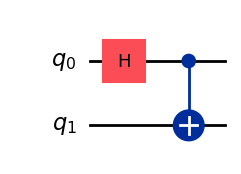

In [6]:
# Hello World
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

qc.draw(output='mpl')

In [7]:
from qiskit.quantum_info import Pauli
ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
XI = Pauli('XI')
IX = Pauli('IX')
XX = Pauli('XX')
observables = [ZZ, ZI, IZ, XI, IX, XX]

In [9]:
# execute on backend
from qiskit_aer.primitives import Estimator
estimator = Estimator()
job = estimator.run([qc] * len(observables), observables)
job.result()

EstimatorResult(values=array([ 1.        , -0.01367188, -0.01367188,  0.03515625,  0.03515625,
        1.        ]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'time_taken': 0.008221996, 'num_bind_params': 1, 'parallel_state_update': 12, 'parallel_shots': 1, 'required_memory_mb': 0, 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'stabilizer', 'device': 'CPU', 'num_qubits': 2, 'sample_measure_time': 0.000295813, 'active_input_qubits': [0, 1], 'num_clbits': 2, 'remapped_qubits': False, 'runtime_parameter_bind': False, 'max_memory_mb': 7335, 'noise': 'ideal', 'measure_sampling': True, 'batched_shots_optimization': False, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.9998130798339844, 'simulator_metadata': [{'time_taken': 0.008221996, 'num_bind_params': 1, 'parallel_state_update': 12, 'parallel_shots': 1, 'required_memory_mb': 0, 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'stabilizer', 'device': 'CPU', 'num_qubits': 2, 'sample_measure_time': 0.0

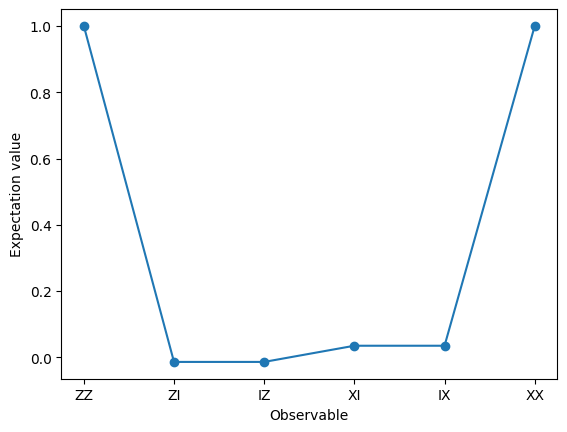

In [12]:
from matplotlib import pyplot as plt
values = job.result().values
data = ['ZZ', 'ZI', 'IZ', 'XI', 'IX', 'XX']
plt.plot(data, values, "-o")
plt.xlabel('Observable')
plt.ylabel('Expectation value')
plt.show()


Bigger Example

In [16]:
# Map problem to circuits and operators
def get_qc_for_n_qubit_GHZ_state(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n-1):
        qc.cx(i, i+1)
    return qc

n = 100
qc = get_qc_for_n_qubit_GHZ_state(n)
#qc.draw(output='mpl')

In [17]:
from qiskit.quantum_info import SparsePauliOp

operator_strings = ['Z' + 'I' * i + 'Z' + 'I' * (n - i - 2) for i in range(n-1)]
operators = [SparsePauliOp(op) for op in operator_strings]

In [20]:
# optimize problem for quantum execution
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = service.backend(name = "ibm_rensselaer")
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled = pass_manager.run(qc)
operators_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in operators]

In [26]:
# execute on backend
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()
options.resilience_level = 1
options.optimization_level = 0
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = 'XY4'

estimator = Estimator(backend, options=options)
job = estimator.run([(qc_transpiled, operators_transpiled_list)])
job_id = job.job_id()
print(job_id)

cw6ssgp2802g00818y80


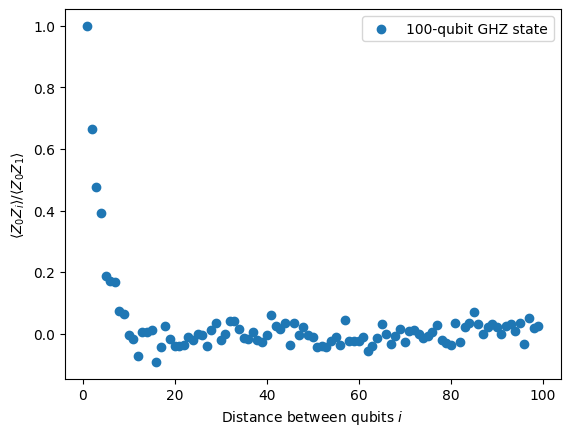

In [27]:
# post process and plot
import matplotlib.pyplot as plt
data = list(range(1, len(operators)+1))
result = job.result()[0]
values = result.data.evs
values = [v / values[0] for v in values]

plt.scatter(data, values, marker='o', label='100-qubit GHZ state')
plt.xlabel('Distance between qubits $i$')
plt.ylabel(r'$\langle Z_0 Z_i \rangle / \langle Z_0 Z_1 \rangle$')
plt.legend()
plt.show()